<a href="https://colab.research.google.com/github/sean-halpin/ml_tweepy_proj/blob/main/svm_text_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install vaderSentiment
!pip install spellchecker
!pip install pyspellchecker
!pip install plot_keras_history

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [ ]:
import numpy as np
import pandas as pd 
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
df = pd.read_csv("tweets_annotated.1650577206.elonmusk.csv")

In [ ]:
stop_words = set(stopwords.words('english'))
def no_stopwords(text):
  tokenwords = word_tokenize(text) 
  result = [w for w in tokenwords if not w in stop_words] 
  result = [] 
  for w in tokenwords: 
      if w not in stop_words: 
          result.append(w)
  return " ".join(result)

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [ ]:
output= string.punctuation
print('list of punctuations:', output)

In [ ]:
df['tweet'] = df['tweet'].str.replace('http\S+|www.\S+|@.\S+|&amp;.\S+|<.*?>', '', case=False)
df['tweet'] = df['tweet'].str.lower()
df['tweet'] = df['tweet'].str.strip()
df['tweet'] = df['tweet'].str.translate(str.maketrans('', '', output))
df['lemmatized_tweet'] = df['tweet'].apply(lemmatize_text).apply(no_stopwords)

In [ ]:
df = df.drop_duplicates('tweet', keep='last')

In [ ]:
X = df.lemmatized_tweet.values.reshape(-1,1)
y = df.sentiment.values.reshape(-1,1)

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X,y)
print(sorted(Counter(y_resampled).items()))

In [ ]:
df_resampled = pd.DataFrame ({ 'lemmatized_tweet': X_resampled.flatten(), 'sentiment': y_resampled})

In [ ]:
df_resampled.head()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled.lemmatized_tweet, df_resampled.sentiment, test_size=0.3, random_state=32)

# Text Classifier

In [ ]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
def clf_metrics(y_test, predicted):
  print(metrics.classification_report(y_test, predicted))
  c_matrix = metrics.confusion_matrix(y_test, predicted)
  ax = sns.heatmap(c_matrix, annot=True,      
                    xticklabels=['negative','neutral','positive'],                
                    yticklabels=['negative','neutral','positive'],                
                  cbar=True, cmap='Blues', fmt='g')
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Actual")

In [ ]:
clf_metrics(y_test, predicted)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, (ax) = plt.subplots(1, 1, figsize=(20, 5))

    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")
    return plt


plot_learning_curve(
    text_clf, "LC ", X=X_test, y=y_test,ylim=(0.1, 1.01), cv=5, n_jobs=-1
)

plt.show()

# Vader

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def vader_sentiment(sentence):
  vs = analyzer.polarity_scores(sentence)
  comp = vs['compound']
  if comp > 0.05:
    return 'positive'
  elif comp < -0.05:
    return 'negative'
  else:
    return 'neutral'

In [ ]:
vader_predicted = X_test.apply(vader_sentiment)

In [ ]:
clf_metrics(y_test, vader_predicted)

In [ ]:
pd.set_option('max_colwidth', -1)

In [ ]:
len(X_test[(y_test == "neutral") & (vader_predicted == "positive")])

In [ ]:
X_test[(y_test == "neutral") & (vader_predicted == "positive")]

# Deep Neural Network Classifier

In [ ]:
import numpy as np
import pandas as pd
import re
import gensim
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
def labels_categorical(data):
  labels = np.array(data)
  y = []
  for i in range(len(labels)):
      if labels[i] == 'neutral':
          y.append(0)
      if labels[i] == 'negative':
          y.append(1)
      if labels[i] == 'positive':
          y.append(2)
  y = np.array(y)
  labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
  del y
  return labels

In [ ]:
labels = labels_categorical(df_resampled.sentiment)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

max_words = 2500
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_resampled.lemmatized_tweet)
sequences = tokenizer.texts_to_sequences(df_resampled.lemmatized_tweet)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.3, random_state=32)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding
embedding_layer = Embedding(1000, 32)

model1 = Sequential()
model1.add(layers.Embedding(max_words, 10))
model1.add(layers.LSTM(90,dropout=0.5, return_sequences=True))
model1.add(layers.LSTM(90,dropout=0.5, return_sequences=True))
model1.add(layers.LSTM(30,dropout=0.5, return_sequences=False))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model1.summary()

In [223]:
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=200,validation_data=(X_test, y_test),callbacks=[checkpoint1])

82/83 [============================>.] - ETA: 0s - loss: 0.9188 - accuracy: 0.5316
Epoch 4: val_accuracy improved from 0.47298 to 0.54827, saving model to best_model1.hdf5
83/83 [==============================] - 1s 16ms/step - loss: 0.9192 - accuracy: 0.5317 - val_loss: 0.9732 - val_accuracy: 0.5483
Epoch 5/200
82/83 [============================>.] - ETA: 0s - loss: 0.8803 - accuracy: 0.5789
Epoch 5: val_accuracy did not improve from 0.54827
83/83 [==============================] - 1s 16ms/step - loss: 0.8793 - accuracy: 0.5792 - val_loss: 0.9822 - val_accuracy: 0.4969
Epoch 6/200
81/83 [============================>.] - ETA: 0s - loss: 0.8386 - accuracy: 0.6076
Epoch 6: val_accuracy did not improve from 0.54827
83/83 [==============================] - 1s 16ms/step - loss: 0.8421 - accuracy: 0.6058 - val_loss: 0.9441 - val_accuracy: 0.5412
Epoch 7/200
81/83 [============================>.] - ETA: 0s - loss: 0.8085 - accuracy: 0.6277
Epoch 7: val_accuracy improved from 0.54827 to 0.55

In [224]:
import keras

best_model = keras.models.load_model("best_model1.hdf5")

In [225]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

36/36 - 1s - loss: 1.0046 - accuracy: 0.6120 - 1s/epoch - 35ms/step
Model accuracy:  0.6120460629463196


In [226]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.51      0.70      0.59       394
           1       0.70      0.55      0.62       363
           2       0.68      0.56      0.61       372

    accuracy                           0.60      1129
   macro avg       0.63      0.60      0.61      1129
weighted avg       0.63      0.60      0.61      1129



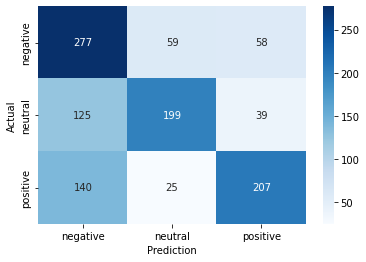

In [227]:
clf_metrics(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

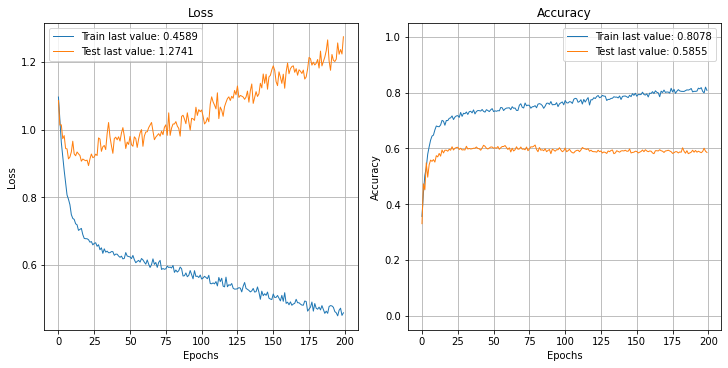

In [228]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history)
plot_history(history, path="standard.png")
plt.close()